# Importing necessary modules and suppress warnings

In [99]:
import math
import random
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as oweptim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import warnings

warnings.filterwarnings('ignore')

# Define training and testing set

In [6]:
TRAIN_PATH = "/kaggle/input/fashionmnist/fashion-mnist_train.csv"
TEST_PATH = "/kaggle/input/fashionmnist/fashion-mnist_test.csv"

In [24]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# Define `utility` function and convert the dataset to `dataloader` batches

In [7]:
def convert_row_to_image_label(row):
    """
    Takes a row and assigns the first column as label and convert the remaining 784 columns to image tensor
    """
    label = row[0]
    pixels = row[1:].values.reshape(28, 28).astype(np.uint8)
    image = Image.fromarray(pixels, mode='L')
    image_tensor = transform(image)
    return image_tensor, label

# Define dataloader

For each of the labels, we are creating a dataloader.

We will define a GAN which consists of 10 `generators` and 10 `discriminators`. Each pair will be trained for each of the 10 type of fashion objects.

In [25]:
train_dfs = [train[train["label"] == i] for i in range(10)]

train_ds = [[convert_row_to_image_label(row) for _, row in df.iterrows()] for df in train_dfs]

In [26]:
dl = [DataLoader(dataset=ds, shuffle=True, batch_size=64) for ds in train_ds]

# Define the mapping between `classes` and `labels`

In [124]:
fashion_mnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [125]:
fashion_mnist_indices = {
    "T-shirt": 0,
    "Trouser": 1,
    "Pullover": 2,
    "Dress": 3,
    "Coat": 4,
    "Sandal": 5,
    "Shirt": 6,
    "Sneaker": 7,
    "Bag": 8,
    "Ankle boot": 9
}


# Define a utility function to print batch of images

T-shirt/top


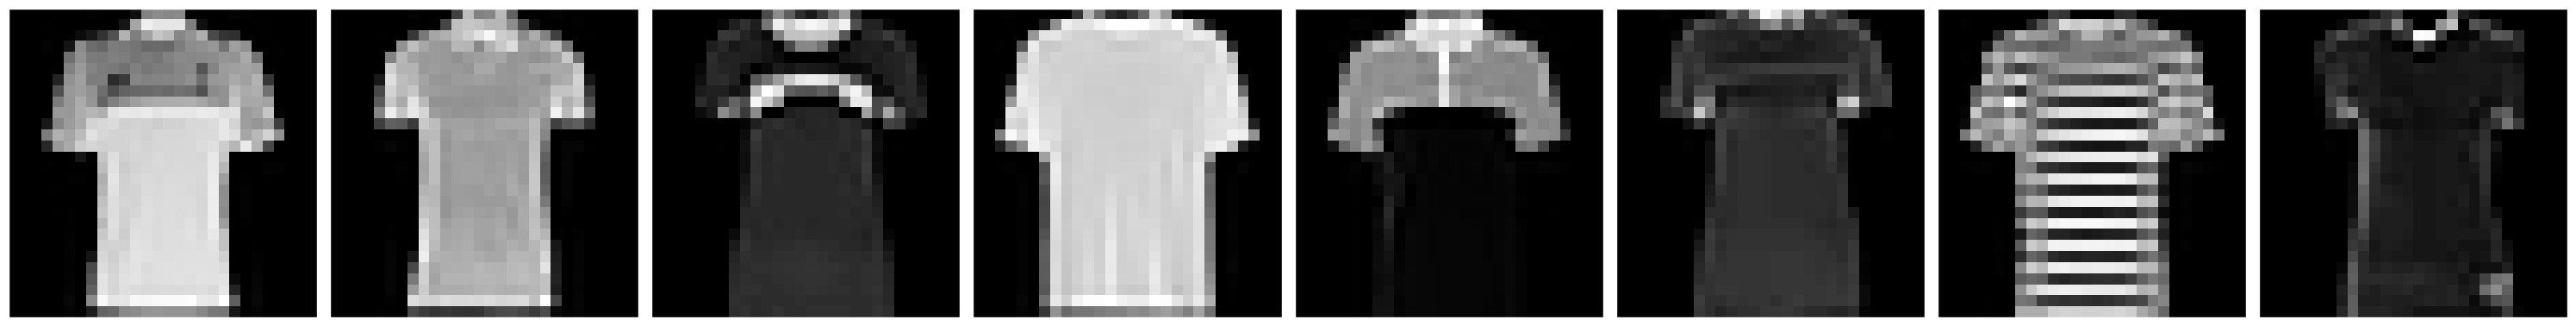

Trouser


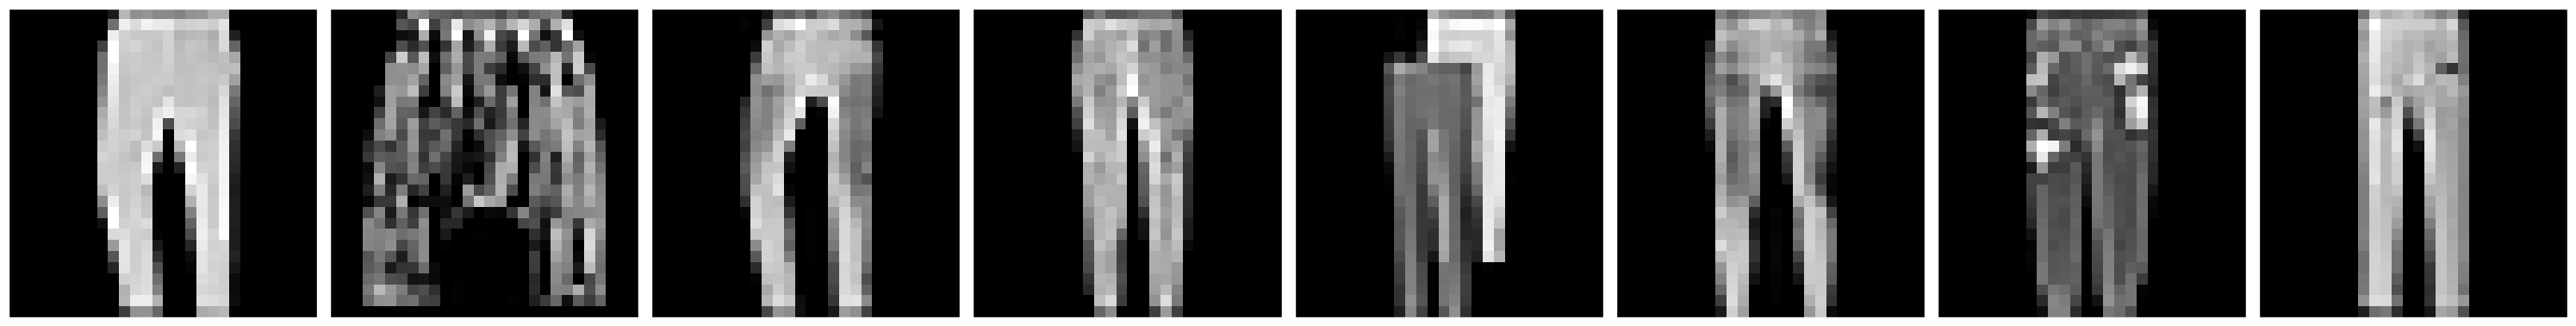

Pullover


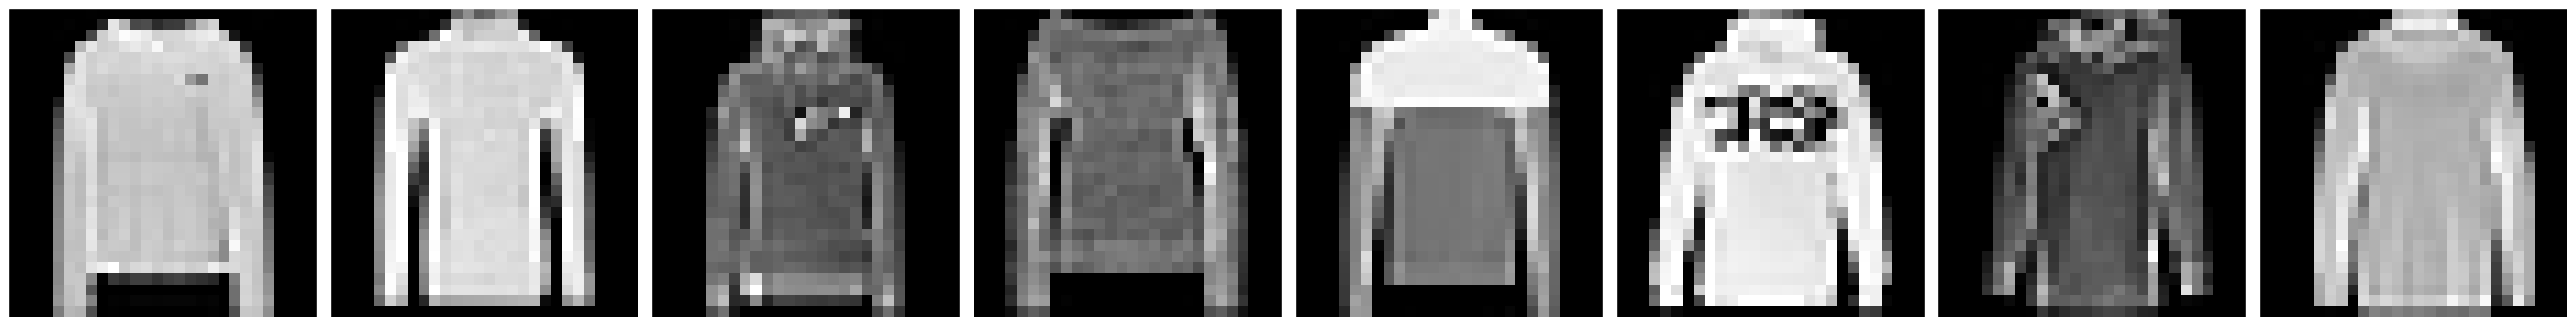

Dress


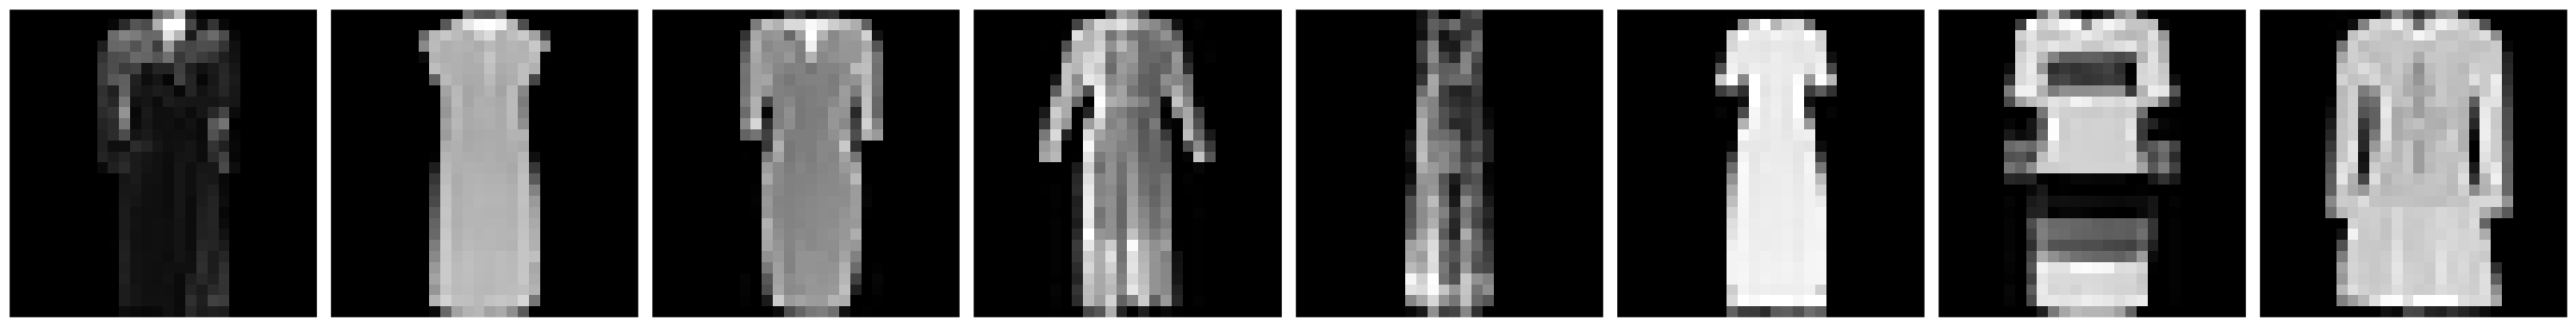

Coat


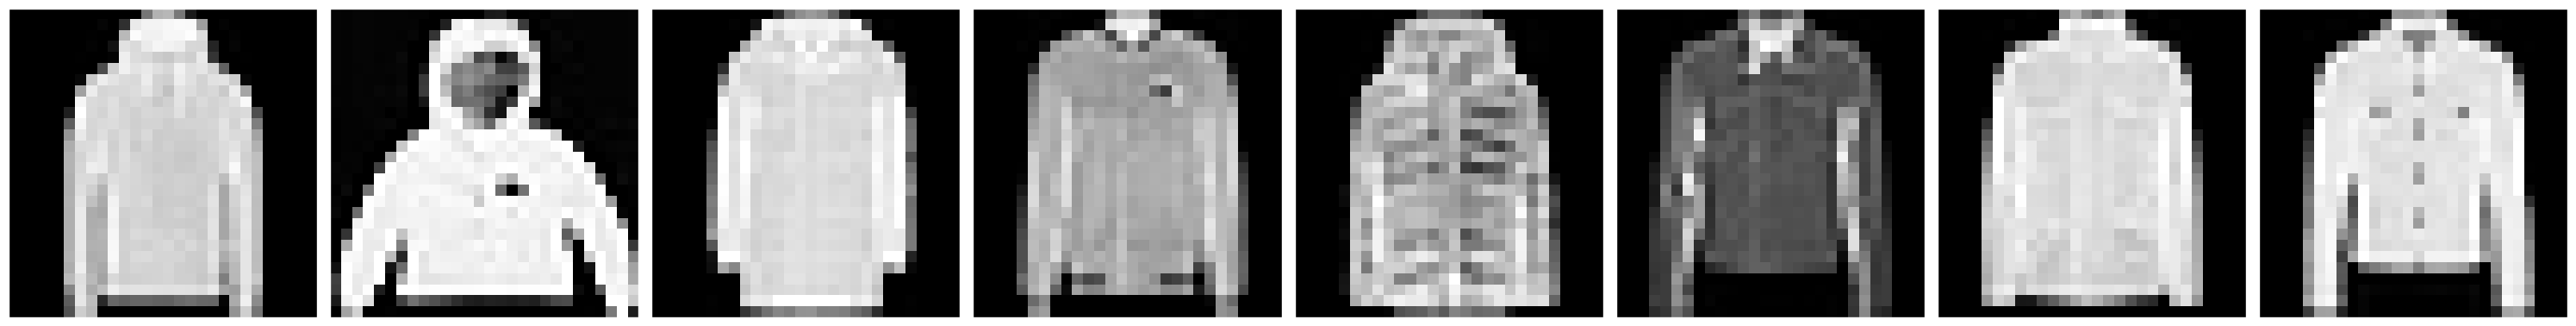

Sandal


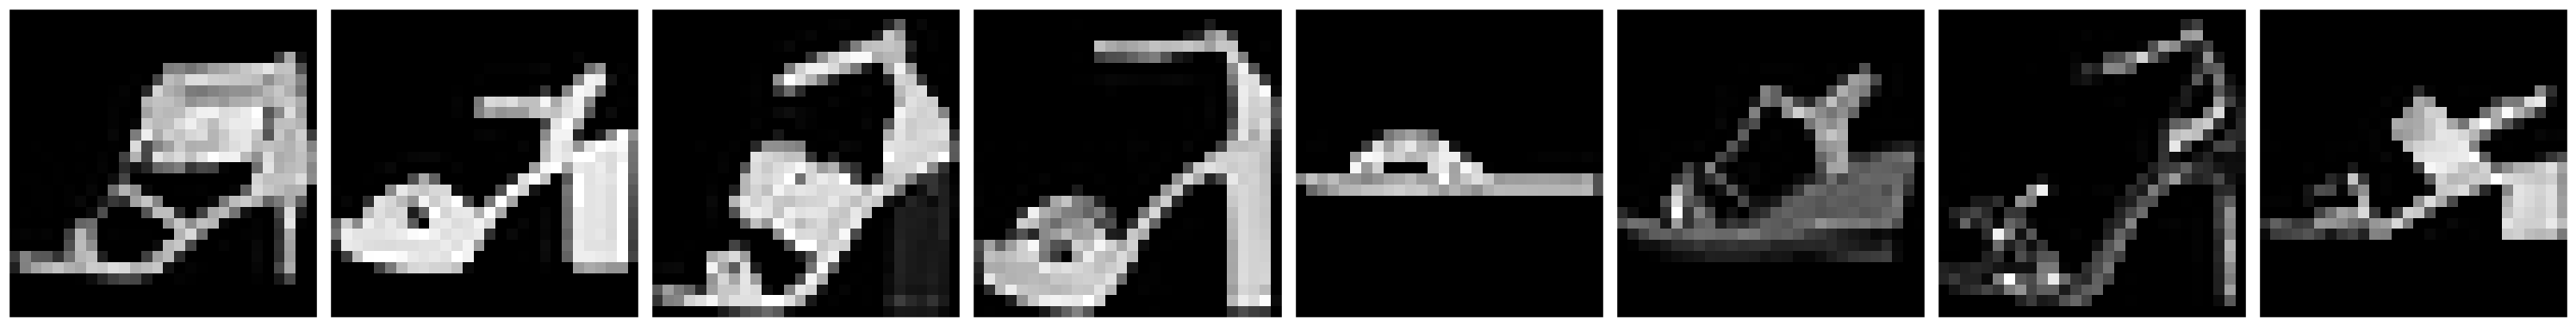

Shirt


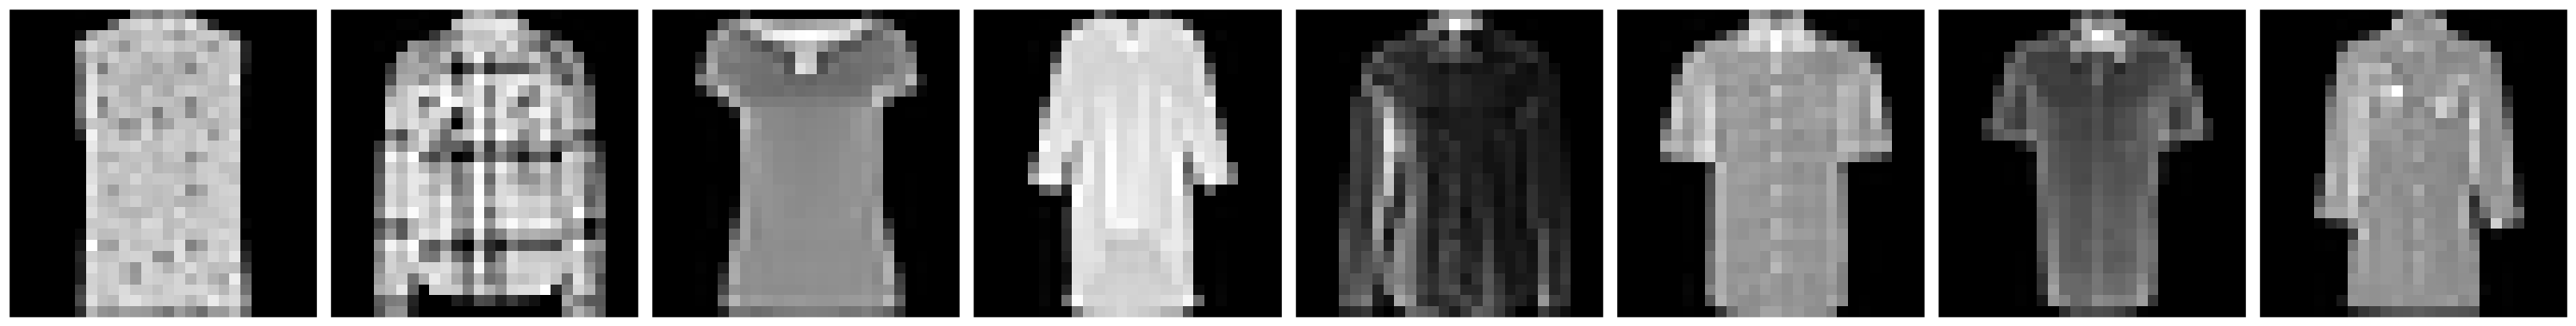

Sneaker


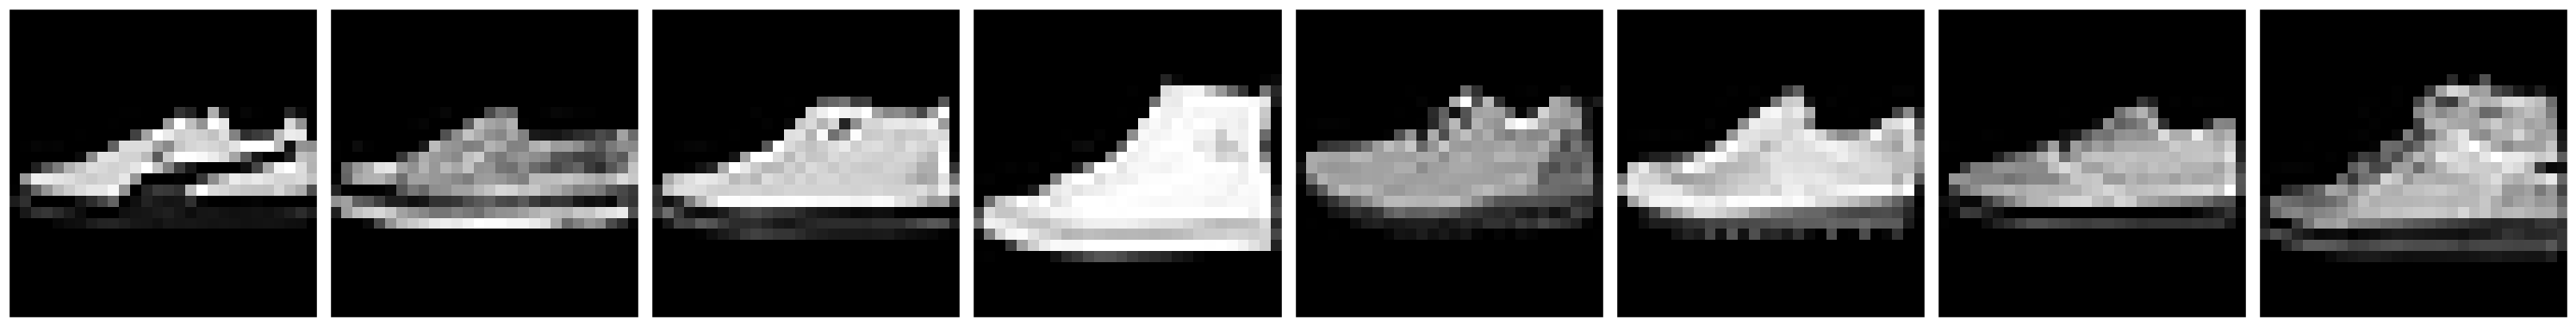

Bag


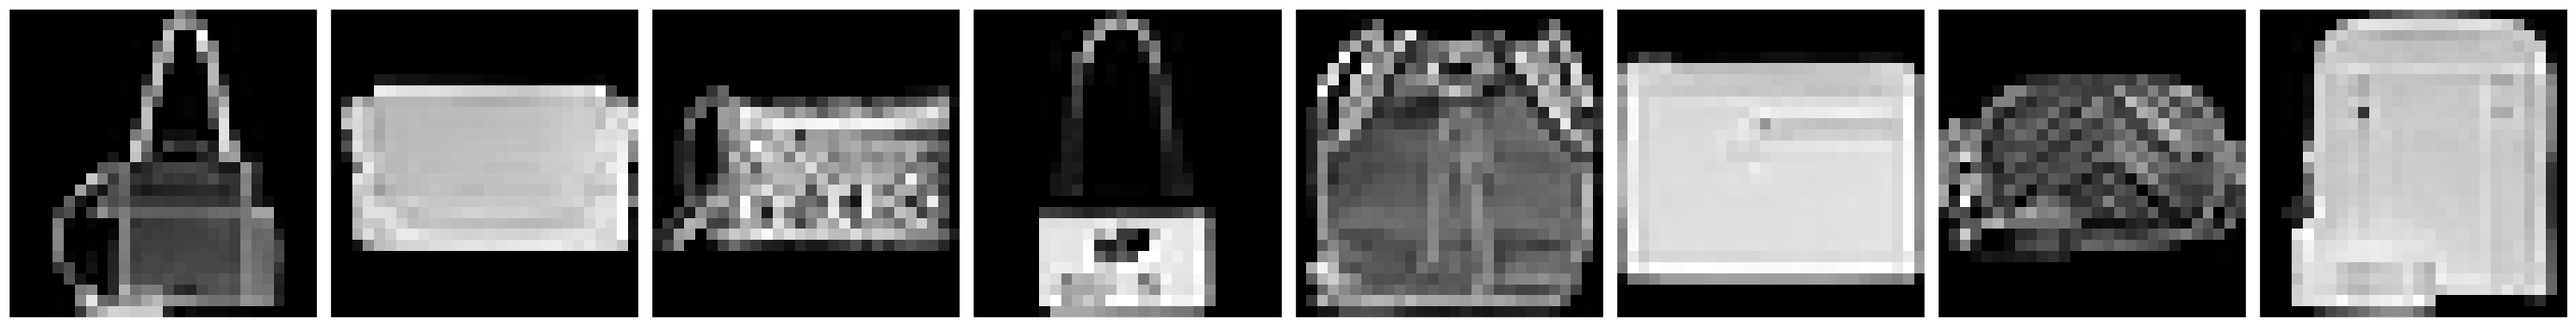

Ankle boot


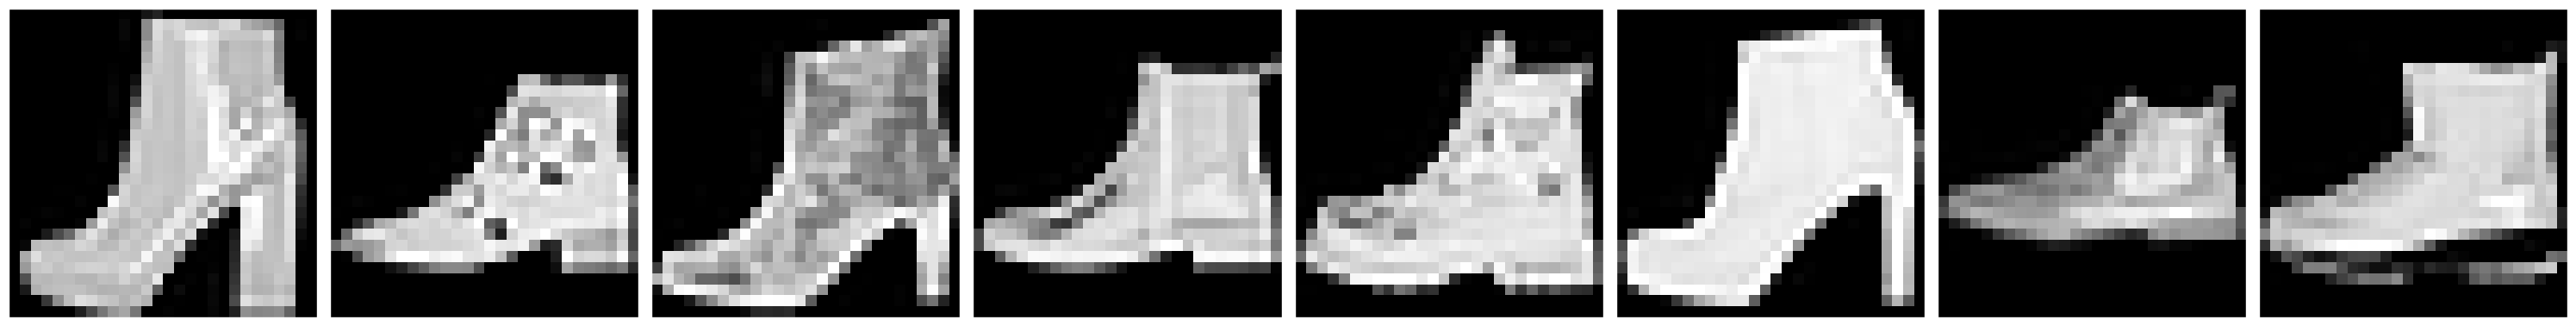

In [82]:
def display_images(images, n_cols=4, figsize=(30, 15), labels=None):
    """
    Utility function to display a collection of images in a grid
    
    Parameters
    ----------
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid
    labels: int[]
            array of the labels for the batch
            
    Returns
    -------
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        
        if labels is not None:
            ax.set_title(str(labels[idx]), fontsize=10)
        
        ax.set_xticks([])
        ax.set_yticks([])        
    plt.tight_layout()
    plt.show()

for i in range(10):
    image_batch = next(iter(dl[i]))
    print(fashion_mnist_labels[i])
    display_images(images=image_batch[0][:8], n_cols=8)

# Discriminator Architecture

## Layer Structure

| Layer | Type | Input Size | Output Size | Activation | Dropout |
|-------|------|------------|-------------|------------|----------|
| 1 | Linear | in_features | 128 | LeakyReLU(0.2) | 0.3 |
| 2 | Linear | 128 | 64 | LeakyReLU(0.2) | 0.3 |
| 3 | Linear | 64 | 32 | LeakyReLU(0.2) | 0.3 |
| 4 | Linear | 32 | out_features | None | None |

## Network Features
- **Input Shape**: (batch_size, in_features)
- **Output Shape**: (batch_size, out_features)
- **Total Layers**: 4 fully connected layers
- **Activation**: LeakyReLU with negative_slope=0.2
- **Regularization**: Dropout with p=0.3 after each hidden layer
- **Architecture Pattern**: Progressive downsampling (in_features → 128 → 64 → 32 → out_features)

## Data Flow
```plaintext
Input → FC1(→128) → LeakyReLU → Dropout 
     → FC2(→64)  → LeakyReLU → Dropout 
     → FC3(→32)  → LeakyReLU → Dropout 
     → FC4(→out) → Output
```

In [16]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)                        
        x = self.fc3(x)
        x = self.leaky_relu3(x)        
        x = self.dropout(x)
        logit_out = self.fc4(x)
        
        return logit_out

# Generator Architecture

## Layer Structure
| Layer | Type | Input Size | Output Size | Activation | Dropout |
|-------|------|------------|-------------|------------|----------|
| 1 | Linear | in_features | 32 | LeakyReLU(0.2) | 0.3 |
| 2 | Linear | 32 | 64 | LeakyReLU(0.2) | 0.3 |
| 3 | Linear | 64 | 128 | LeakyReLU(0.2) | 0.3 |
| 4 | Linear | 128 | out_features | Tanh | None |

## Network Features
- **Input Shape**: (batch_size, in_features)
- **Output Shape**: (batch_size, out_features)
- **Total Layers**: 4 fully connected layers
- **Hidden Activation**: LeakyReLU with negative_slope=0.2
- **Output Activation**: Tanh
- **Regularization**: Dropout with p=0.3 after each hidden layer
- **Architecture Pattern**: Progressive upsampling (in_features → 32 → 64 → 128 → out_features)

## Data Flow
```plaintext
Input → FC1(→32)  → LeakyReLU → Dropout 
     → FC2(→64)  → LeakyReLU → Dropout 
     → FC3(→128) → LeakyReLU → Dropout 
     → FC4(→out) → Tanh     → Output
```

<details>

<summary>Note</summary>

This generator is essentially a mirror of the discriminator, but with reversed dimensionality (expanding instead of contracting) and a Tanh activation at the output instead of raw logits.

</details>

In [17]:
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=128, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)        
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)        
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)
        
        return tanh_out

# Defining loss functions
- real loss: denotes the loss when provided images are real.
```python
targets = torch.ones(batch_size).to(device)
```
- fake loss: denotes the loss when provided images are fake.
```python
targets = torch.zeros(batch_size).to(device)
```

In [18]:
def real_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are drawn from real dataset
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    real_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are generated fake samples
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    fake_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return fake_loss 

# We will use this variable to store images for some epochs

In [75]:
gan_output_samples = [None]*10

# Training Function for MNIST GAN

The `train_mnist_gan` function is responsible for training a Generative Adversarial Network (GAN) using a Discriminator and a Generator model on the MNIST dataset. The function optimizes both models using their respective loss functions and optimizers.

## Function Definition

```python
def train_mnist_gan(discriminator, generator, d_optim, g_optim, loss_fn, dl, n_epochs, label, device):
```

### Parameters
- **`discriminator`**: The discriminator model that distinguishes between real and fake images.
- **`generator`**: The generator model that creates fake images from random noise.
- **`d_optim`**: The optimizer for the discriminator.
- **`g_optim`**: The optimizer for the generator.
- **`loss_fn`**: The loss function used to compute the losses for both models.
- **`dl`**: The data loader providing batches of real images from the MNIST dataset.
- **`n_epochs`**: The number of epochs for training.
- **`label`**: A label used to store generated samples.
- **`device`**: The device to which the models and tensors should be moved (e.g., CPU or GPU).

## Initialization

- **Latent Space Size**: The size of the random noise vector `z` is set to 100.
- **Fixed Noise**: A fixed noise vector `fixed_z` is generated to visualize the generator's output during training.
- **Loss Tracking**: Two lists, `d_losses` and `g_losses`, are initialized to keep track of discriminator and generator losses respectively.

```python
z_size = 100
fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
fixed_z = torch.from_numpy(fixed_z).float().to(device)
fixed_samples = []
d_losses = []
g_losses = []
```

## Training Loop

The training loop iterates over the number of epochs specified by `n_epochs`.

### Epoch Loop

- **Set Models to Training Mode**: Both the discriminator and generator are set to training mode.
- **Batch Loss Tracking**: Running batch losses are initialized for both models.

### Batch Loop

For each batch of real images:
1. **Move Real Images to Device**: Real images are transferred to the specified device.
2. **Discriminator Training**:
    - **Zero Gradients**: The gradients for the discriminator optimizer are reset.
    - **Normalize Real Images**: Real images are scaled from [0, 1] to [-1, 1].
    - **Calculate Real Loss**: The discriminator outputs logits for real images, and the loss is calculated.
   
3. **Generate Fake Images**:
    - **Noise Sampling**: Random noise `z` is generated.
    - **Generate Fake Images**: The generator produces fake images using the noise.
    - **Calculate Fake Loss**: The discriminator outputs logits for fake images, and the loss is calculated.

4. **Backpropagation**:
    - **Total Discriminator Loss**: The total discriminator loss is calculated and backpropagated.
    - **Optimizer Step**: The discriminator optimizer updates the weights.

5. **Generator Training**:
    - **Zero Gradients**: The gradients for the generator optimizer are reset.
    - **Generate Fake Images**: Random noise `z` is generated again.
    - **Discriminator Logits**: The discriminator outputs logits for the newly generated fake images.
    - **Calculate Generator Loss**: The generator's loss is calculated based on the discriminator's logits.
    - **Backpropagation**: The generator loss is backpropagated and the optimizer updates the weights.

### Loss Tracking

After processing all batches for the epoch:
- The average loss for both the discriminator and generator is computed and appended to their respective lists.
- Loss values are printed every 20 epochs.

```python
d_epoch_loss = d_running_batch_loss.item()/len(dl)
g_epoch_loss = g_running_batch_loss.item()/len(dl)
```

### Generating Samples

At the end of each epoch, the generator is set to evaluation mode, and the generated samples from the fixed noise `fixed_z` are stored for visualization later.

```python
generator.eval()
fixed_samples.append(generator(fixed_z).detach().cpu())
```

## Return Values

The function returns the lists of discriminator and generator losses over the epochs:

```python
return d_losses, g_losses
```

In [107]:
def train_mnist_gan(discriminator, generator, d_optim, g_optim, loss_fn, dl, n_epochs, label, device):
    """
    Train a Generative Adversarial Network (GAN) on the Fashion MNIST dataset.

    Parameters
    ----------
    discriminator: nn.Module
        The discriminator model used to differentiate between real and fake images.
    
    generator: nn.Module
        The generator model that creates fake images from random noise.
    
    d_optim: torch.optim.Optimizer
        The optimizer for updating the discriminator's weights.
    
    g_optim: torch.optim.Optimizer
        The optimizer for updating the generator's weights.
    
    loss_fn: callable
        The loss function used for training the models, typically binary cross-entropy.
    
    dl: DataLoader
        The DataLoader providing the training dataset.
    
    n_epochs: int
        The number of training epochs to run.
    
    label: int
        The label of the class being trained (0-9 for Fashion MNIST).
    
    device: str
        The device to run the training on ('cuda' for GPU or 'cpu').
    
    Returns
    -------
    d_losses: list
        A list containing the discriminator's loss for each epoch.
    
    g_losses: list
        A list containing the generator's loss for each epoch.
    """
    z_size = 100
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)          
    fixed_samples = []
    d_losses = []
    g_losses = []
    
    
    discriminator = discriminator.to(device)
    generator = generator.to(device)
    
    for epoch in range(n_epochs):
        discriminator.train()
        generator.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for curr_batch, (real_images, _) in enumerate(dl):
            real_images = real_images.to(device)
            
           
            d_optim.zero_grad()
            
            
            real_images = (real_images * 2) - 1  
            d_real_logits_out = discriminator(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            
            with torch.no_grad():
                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                fake_images = generator(z) 
            d_fake_logits_out = discriminator(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optim.step()
            d_running_batch_loss += d_loss
            
            g_optim.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)       
            fake_images = generator(z) 
            g_logits_out = discriminator(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            g_loss.backward()
            g_optim.step()
            g_running_batch_loss += g_loss
            
        d_epoch_loss = d_running_batch_loss.item()/len(dl)
        g_epoch_loss = g_running_batch_loss.item()/len(dl)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)
        
        if((epoch - 19) % 20 == 0):
            print(f'Epoch [{epoch+1}/{n_epochs}]:')
            print(f'discriminator loss: {d_epoch_loss:.6f} \tgenerator loss: {g_epoch_loss:.6f}')
        
        generator.eval()
        fixed_samples.append(generator(fixed_z).detach().cpu())
    
    gan_output_samples[label] = fixed_samples
     
    return d_losses, g_losses


# Training Multiple GANs for Fashion MNIST

The following code demonstrates how to train a Generative Adversarial Network for the Fashion MNIST dataset. The GAN consists of 10 pairs of discriminator and a generator, optimized with their respective loss functions and trained on a particular class of images.

## Initialization

### Discriminators and Generators

The code initializes a list of 10 discriminators and 10 generators, one for each class in the Fashion MNIST dataset:

```python
discriminators = [Discriminator(in_features=784, out_features=1) for _ in range(10)]
generators = [Generator(in_features=100, out_features=784) for _ in range(10)]
```

- **Discriminator**: The discriminator is defined to take a flattened image of size 784 (28x28) as input and produce a single output (logit) indicating whether the image is real or fake.
- **Generator**: The generator takes a noise vector of size 100 and outputs a flattened image of size 784.

### Optimizers

Adam optimizers are created for each discriminator and generator:

```python
d_optims = [optim.Adam(d.parameters(), lr=0.002) for d in discriminators]
g_optims = [optim.Adam(g.parameters(), lr=0.002) for g in generators]
```

- Each optimizer is configured with a learning rate of 0.002.

### Loss Functions

Binary Cross-Entropy loss is defined for each GAN:

```python
loss_fns = [nn.BCEWithLogitsLoss() for i in range(10)]
```

- This loss function combines a sigmoid layer and the binary cross-entropy loss in one single class, which is suitable for binary classification tasks.

### Device Configuration

The code checks for GPU availability and sets the device accordingly:

```python
device = 'cuda' if torch.cuda.is_available() else 'cpu'
```

## Training Configuration

- **Number of Epochs**: The number of training epochs is set to 100.

```python
n_epochs = 100
```

- **Loss Storage**: Two lists, `d_losses` and `g_losses`, are initialized to store the losses for each GAN.

```python
d_losses = [None] * 10
g_losses = [None] * 10
```

## Training Loop

The code iterates over each class (0 to 9) in the Fashion MNIST dataset and trains the corresponding GAN:

```python
for i in range(10):
    print(f"Training GAN for {fashion_mnist_labels[i]} on {device}")
    d_losses[i], g_losses[i] = train_mnist_gan(discriminators[i], generators[i], d_optims[i], g_optims[i], loss_fns[i], dl[i], n_epochs, i, device)
```

- **Training Message**: For each class, a message is printed to indicate which GAN is being trained and on which device (GPU or CPU).
- **Training Call**: The `train_mnist_gan` function is called for each class, passing in the respective models, optimizers, loss functions, data loaders (`dl[i]`), number of epochs, label index, and device.

In [108]:
discriminators = [Discriminator(in_features=784, out_features=1) for _ in range(10)]
generators = [Generator(in_features=100, out_features=784) for _ in range(10)]

d_optims = [optim.Adam(d.parameters(), lr=0.002) for d in discriminators]
g_optims = [optim.Adam(g.parameters(), lr=0.002) for g in generators]

loss_fns = [nn.BCEWithLogitsLoss() for i in range(10)]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_epochs = 100
d_losses = [None] * 10
g_losses = [None] * 10
for i in range(10):
    print(f"Training GAN for {fashion_mnist_labels[i]} on {device}")
    d_losses[i], g_losses[i] = train_mnist_gan(discriminators[i], generators[i], d_optims[i], g_optims[i], loss_fns[i], dl[i], n_epochs, i, device)
    
with open('gan_output_samples.pkl', 'wb') as f:
    pkl.dump(gan_output_samples, f)

Training GAN for T-shirt/top on cuda
Epoch [20/100]:
discriminator loss: 1.050798 	generator loss: 1.543833
Epoch [40/100]:
discriminator loss: 1.295060 	generator loss: 0.987070
Epoch [60/100]:
discriminator loss: 1.243364 	generator loss: 1.147118
Epoch [80/100]:
discriminator loss: 1.314434 	generator loss: 1.074198
Epoch [100/100]:
discriminator loss: 1.330188 	generator loss: 1.088958
Training GAN for Trouser on cuda
Epoch [20/100]:
discriminator loss: 1.339328 	generator loss: 0.761297
Epoch [40/100]:
discriminator loss: 1.300080 	generator loss: 1.008697
Epoch [60/100]:
discriminator loss: 1.152814 	generator loss: 1.133060
Epoch [80/100]:
discriminator loss: 1.310656 	generator loss: 1.194676
Epoch [100/100]:
discriminator loss: 1.243475 	generator loss: 0.982429
Training GAN for Pullover on cuda
Epoch [20/100]:
discriminator loss: 1.128120 	generator loss: 1.520040
Epoch [40/100]:
discriminator loss: 1.080666 	generator loss: 1.293543
Epoch [60/100]:
discriminator loss: 1.1977

# To plot the losses of each pair of generator and discriminator

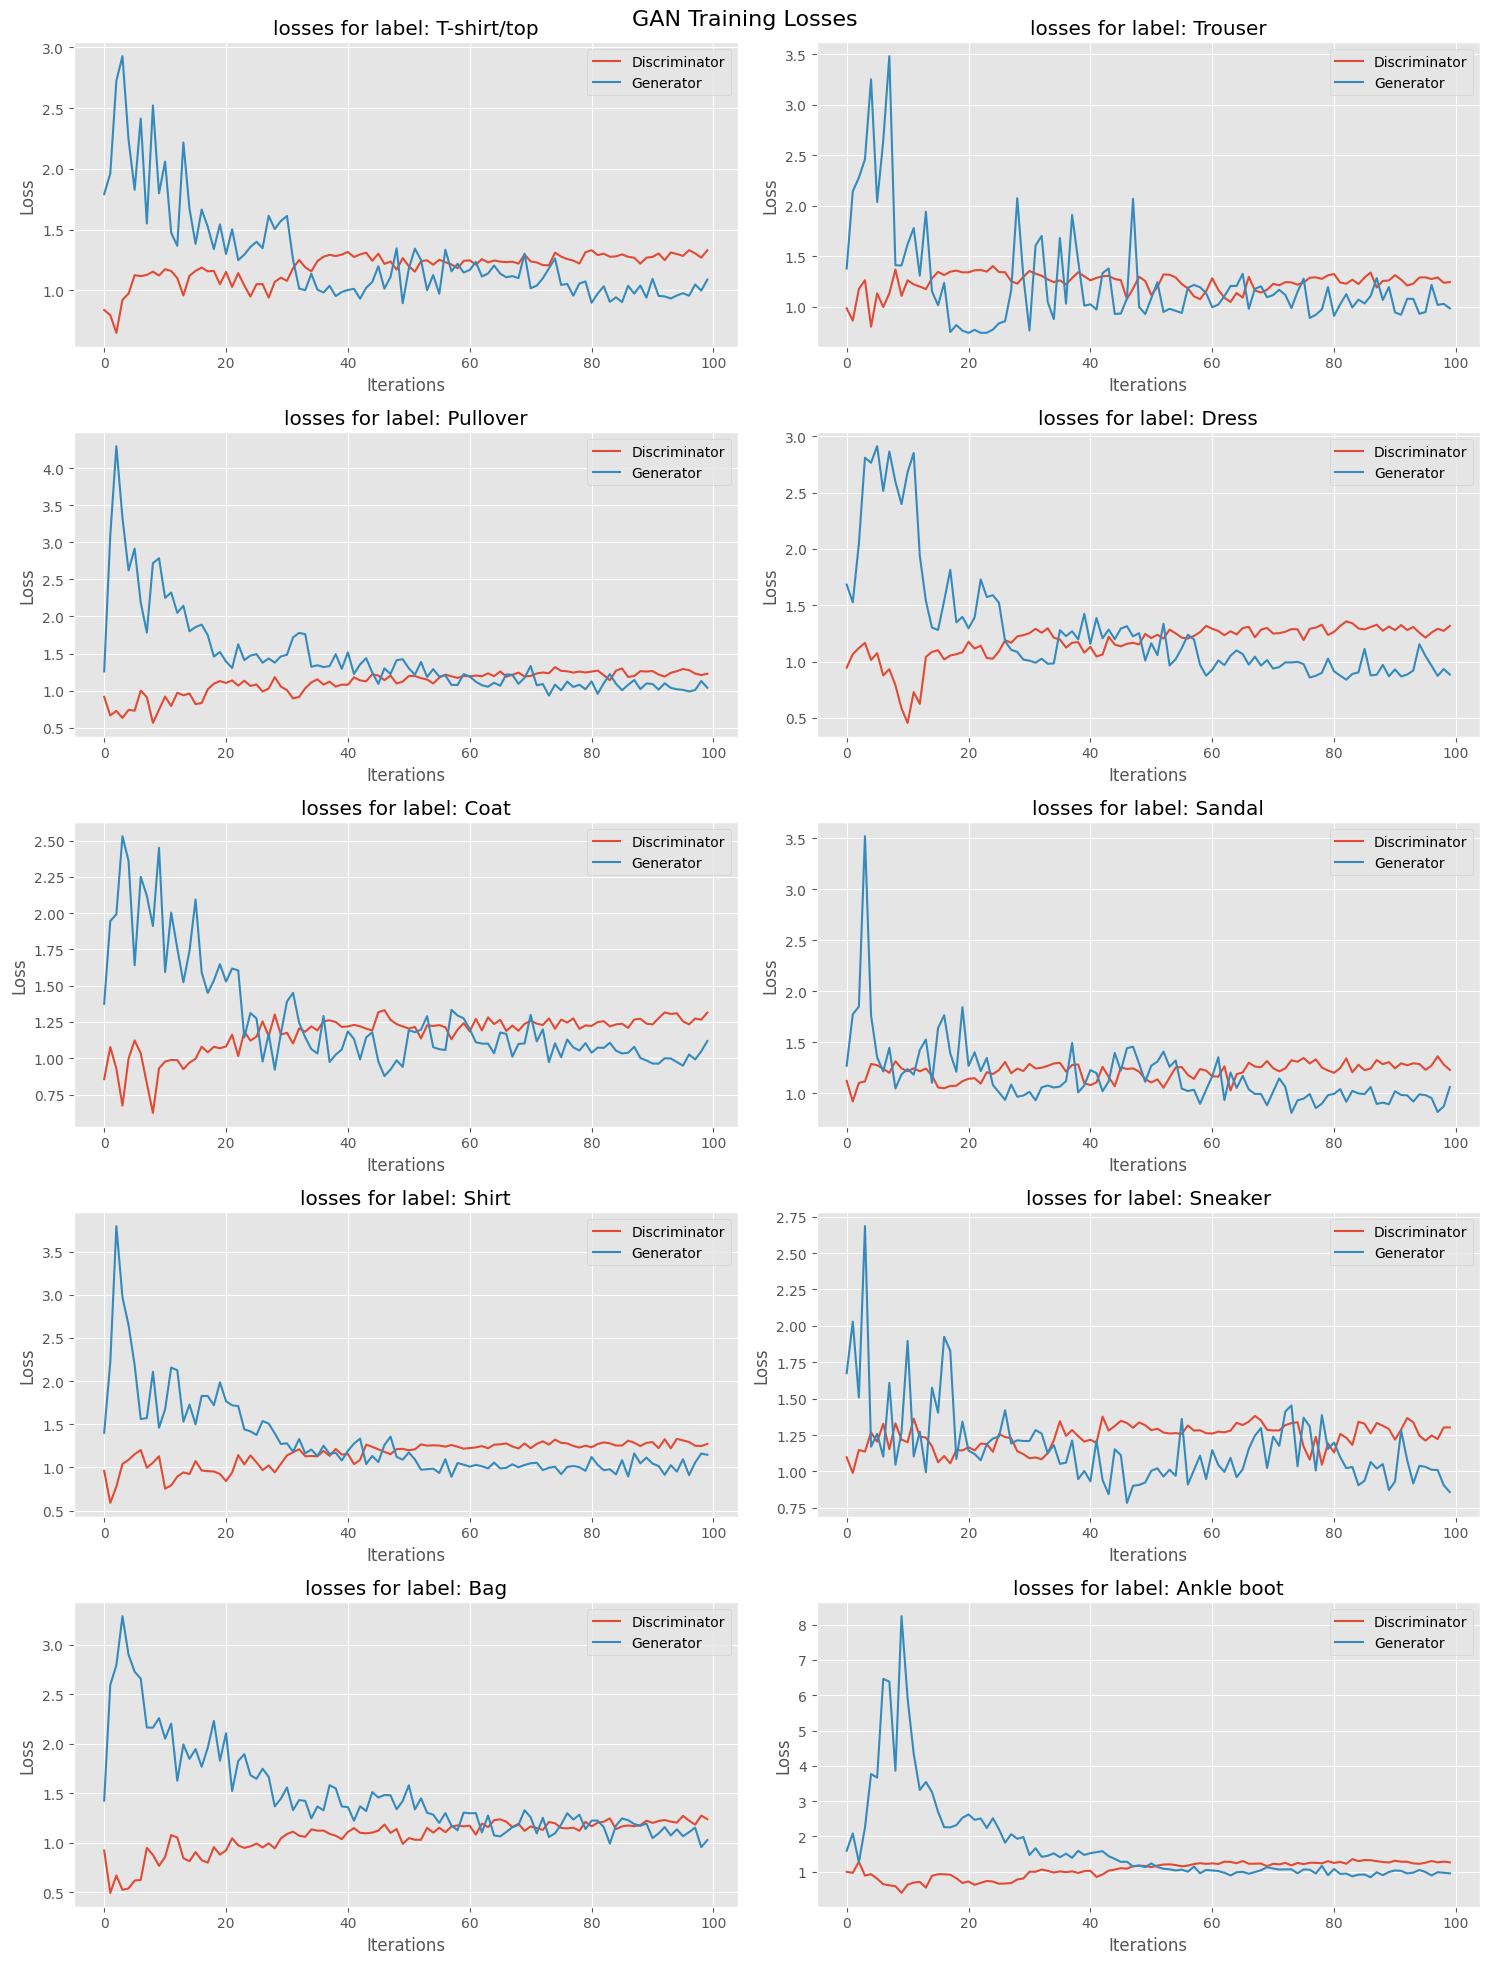

In [109]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('GAN Training Losses', fontsize=16)

axes = axes.flatten()

for i in range(10):
    axes[i].plot(d_losses[i], label='Discriminator')
    axes[i].plot(g_losses[i], label='Generator')
    axes[i].legend()
    axes[i].set_title(f'losses for label: {fashion_mnist_labels[i]}')
    axes[i].set_xlabel('Iterations')
    axes[i].set_ylabel('Loss')
    
plt.tight_layout()
plt.show()

# Print images over epochs to show improvement of the `generator`

In [100]:
def show_gan_generated_images(label, n_cols=8):
    """
    Display generated images from a trained GAN for a specific label at different training epochs.
    
    Parameters
    ----------
    label: int
        The label corresponding to the class of images generated by the GAN (0-9 for Fashion MNIST).
    
    n_cols: int, optional
        The number of columns in the image grid (default is 8).
        
    Returns
    -------
    None
        Displays the generated images in a grid format using the `display_images` function.
    """
    with open('gan_output_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)
    sample_images = []
    sample_labels = []
    for epoch in [1, 5, 10, 20, 30, 50, 75, 100]:
        epoch_data = saved_data[label][epoch-1]
        epoch_data = (epoch_data + 1) / 2
        batch_size, channel, height, width = len(epoch_data), 1, 28, 28
        image_batch = epoch_data.view(batch_size, channel, height, width)
        random_index = random.randint(0, batch_size - 1)  # Generates a random index in the range [0, batch_size-1]
        sample_images.append(image_batch[random_index])
        sample_labels.append(f"After epoch {epoch}")
        
    display_images(images=sample_images, n_cols=n_cols, figsize=(12, 4), labels=sample_labels)

Generator for T-shirt/top


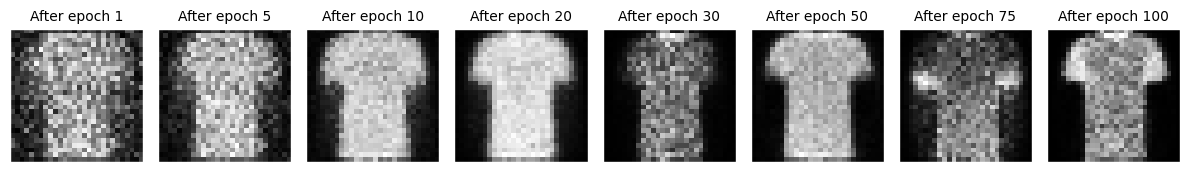

Generator for Trouser


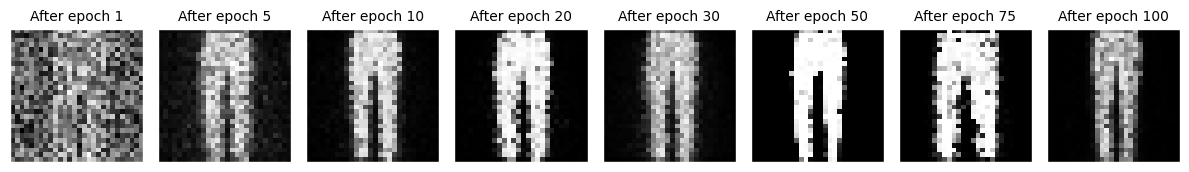

Generator for Pullover


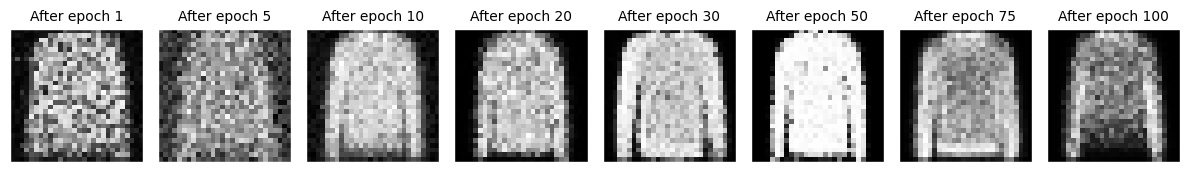

Generator for Dress


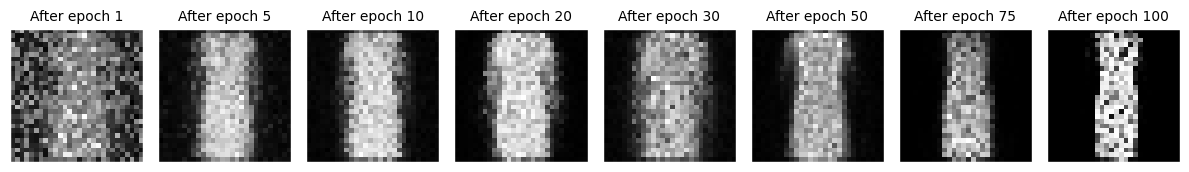

Generator for Coat


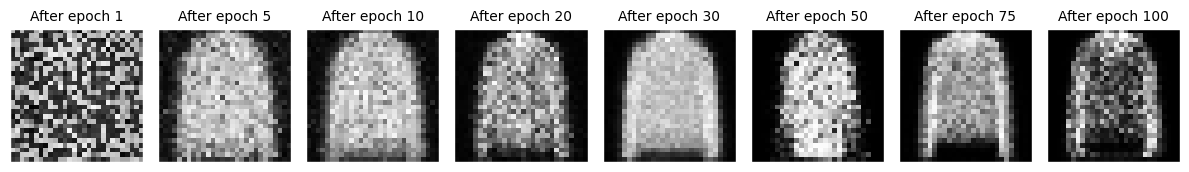

Generator for Sandal


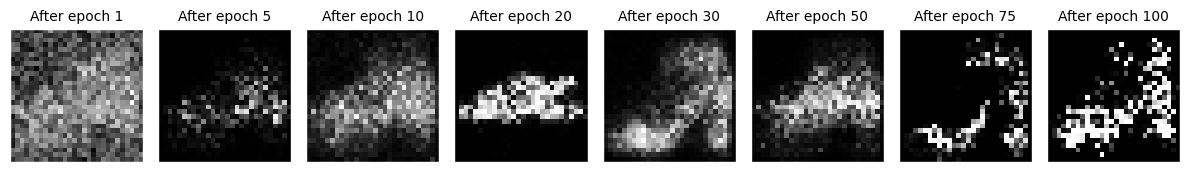

Generator for Shirt


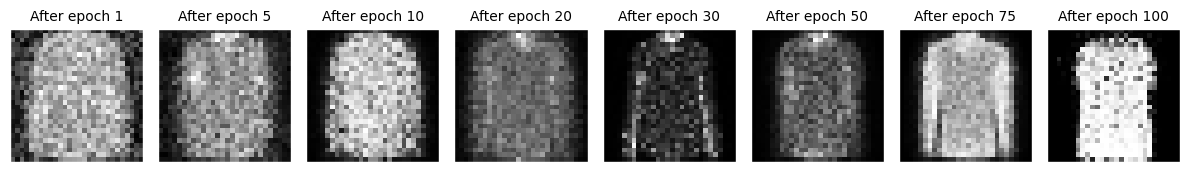

Generator for Sneaker


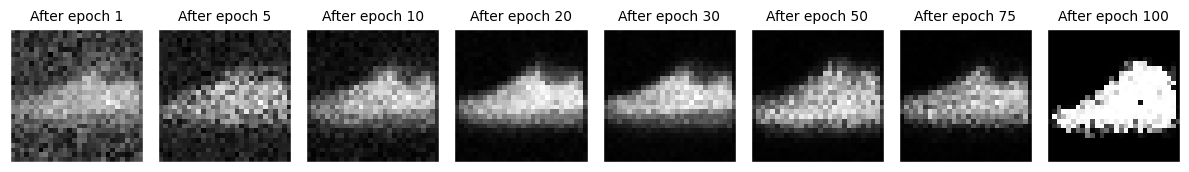

Generator for Bag


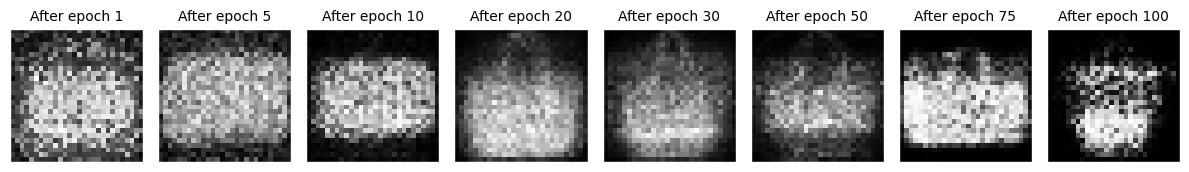

Generator for Ankle boot


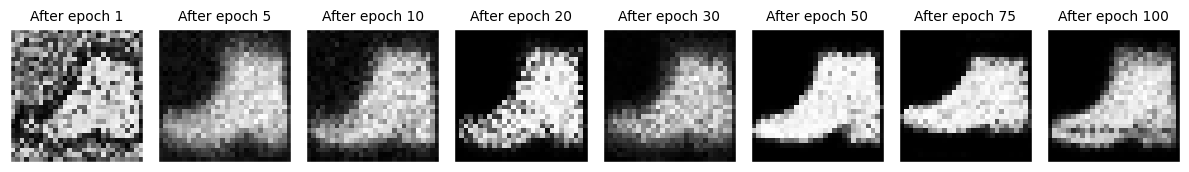

In [101]:
for label in range(10):
    print(f"Generator for {fashion_mnist_labels[label]}")
    show_gan_generated_images(label, n_cols=8)

Generator for T-shirt/top


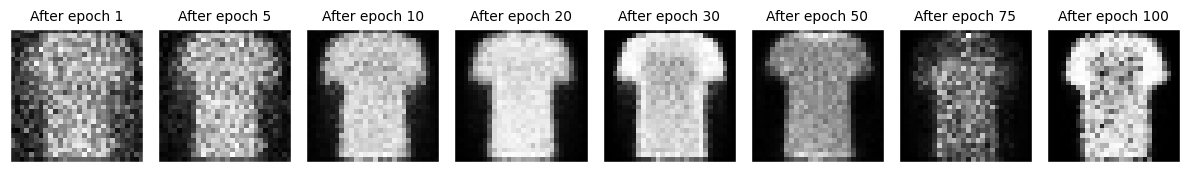

Generator for Trouser


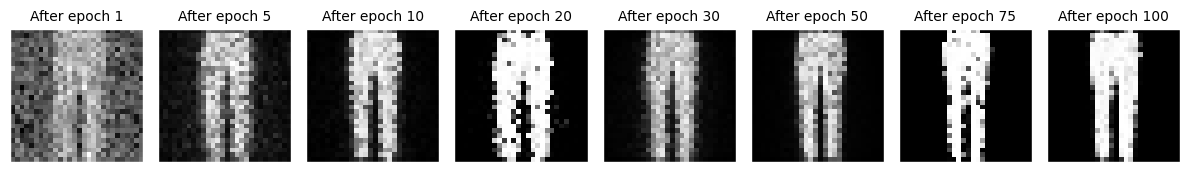

Generator for Pullover


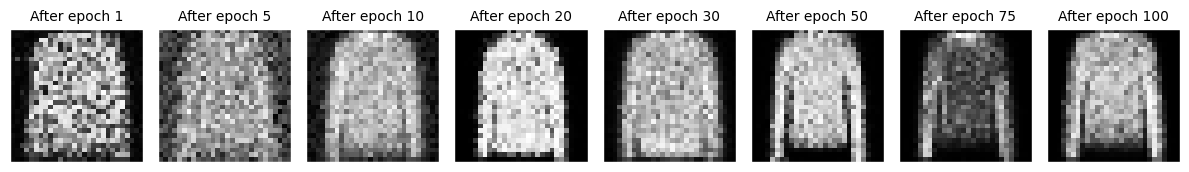

Generator for Dress


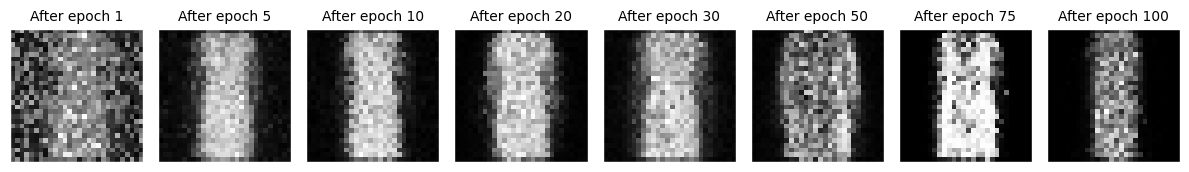

Generator for Coat


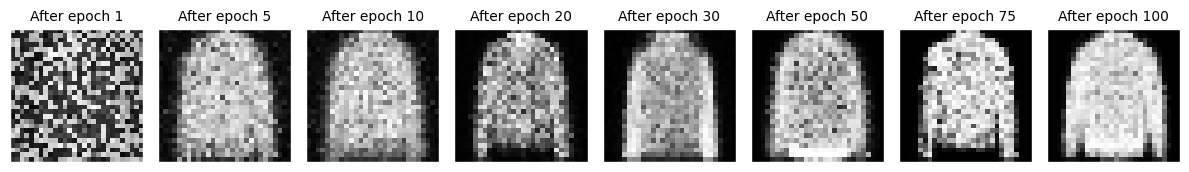

Generator for Sandal


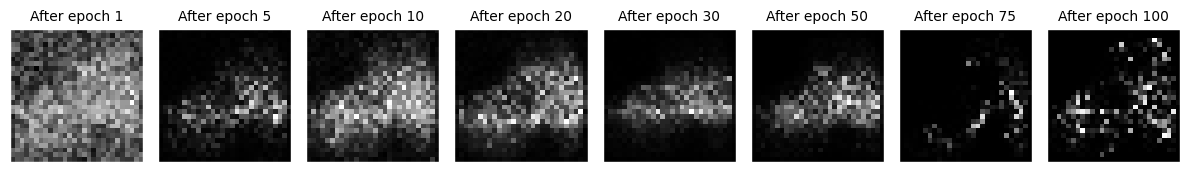

Generator for Shirt


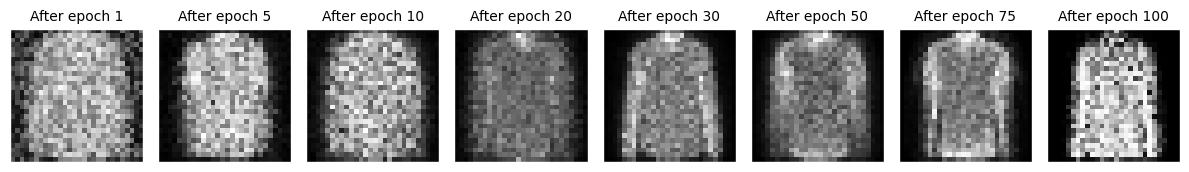

Generator for Sneaker


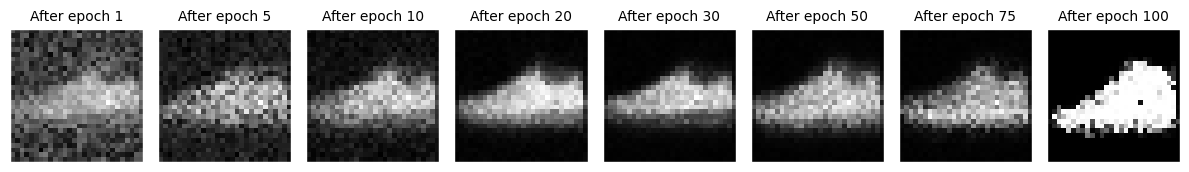

Generator for Bag


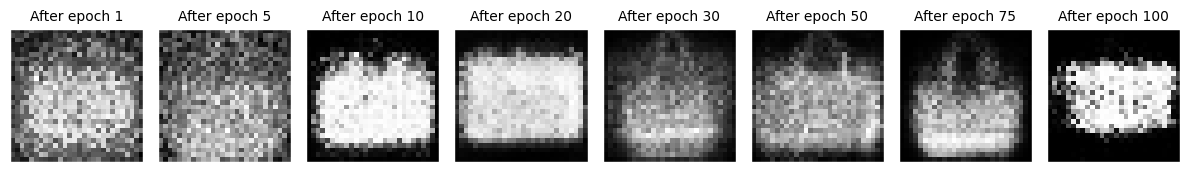

Generator for Ankle boot


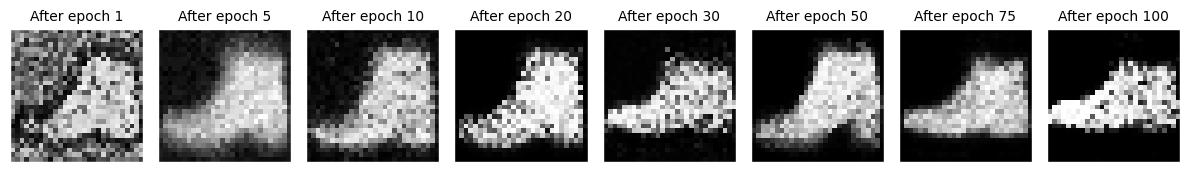

In [102]:
for label in range(10):
    print(f"Generator for {fashion_mnist_labels[label]}")
    show_gan_generated_images(label, n_cols=8)

Generator for T-shirt/top


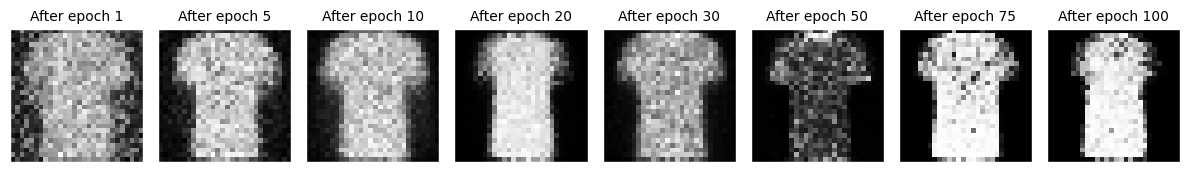

Generator for Trouser


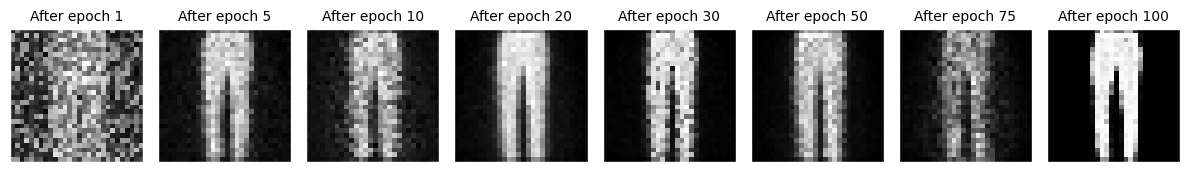

Generator for Pullover


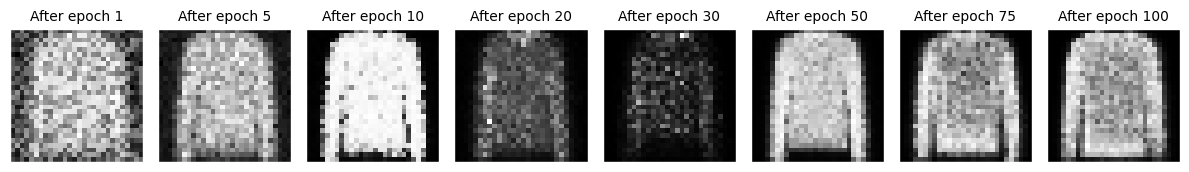

Generator for Dress


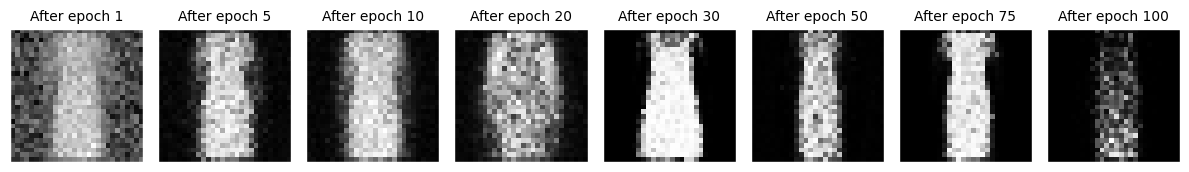

Generator for Coat


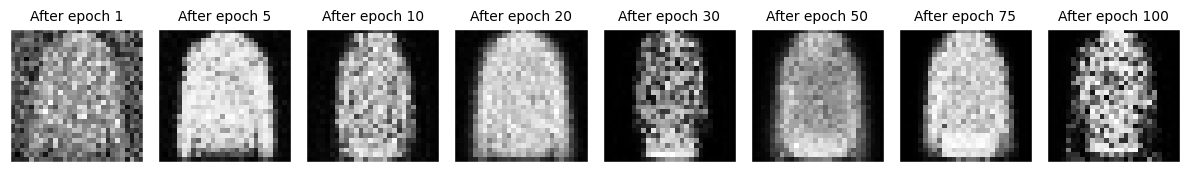

Generator for Sandal


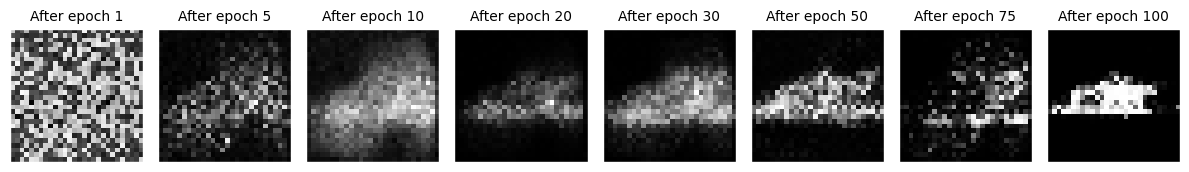

Generator for Shirt


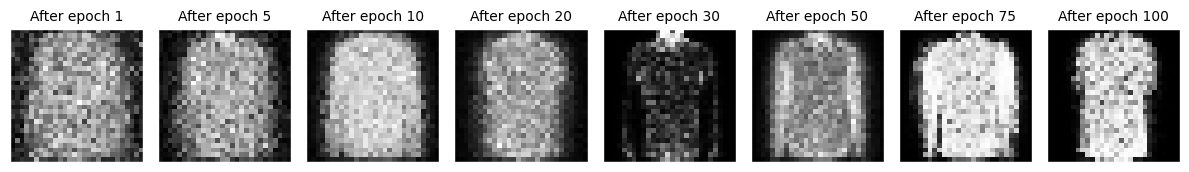

Generator for Sneaker


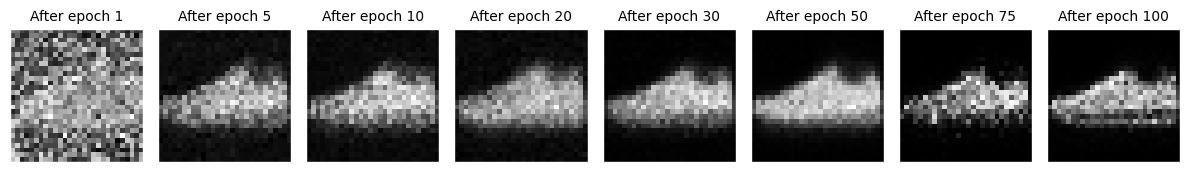

Generator for Bag


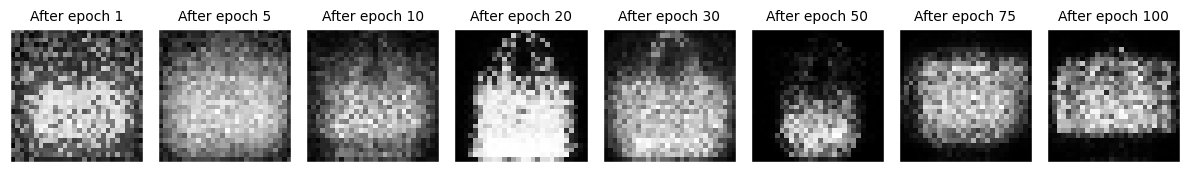

Generator for Ankle boot


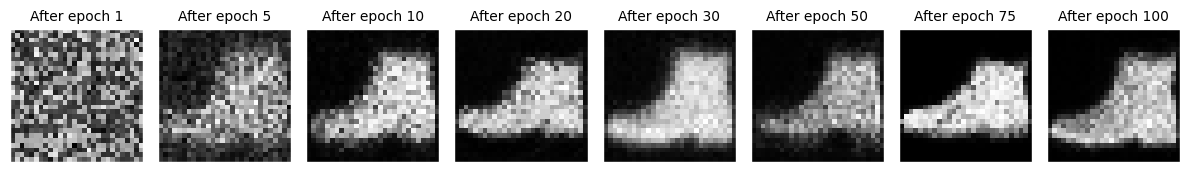

In [110]:
for label in range(10):
    print(f"Generator for {fashion_mnist_labels[label]}")
    show_gan_generated_images(label, n_cols=8)

# The function `generate(label)`, given a label, generates an image of that label

Notes
- The generator corresponding to the specified label is set to evaluation mode and moved to the CPU for 
      image generation.
- A random input vector `z` is generated from a uniform distribution between -1 and 1, which serves as input 
      to the generator.
- The generated image is reshaped to match the dimensions of the Fashion MNIST dataset (1, 28, 28).
- The label of the generated image is printed using the `fashion_mnist_labels` dictionary.
- The generated image is displayed using the `display_images` function.

In [130]:
def generate(label):
    """
    Generate a fake image using the specified generator for the given label.

    Parameters
    ----------
    label: int or str
        The label for which to generate a fake image. If a string is provided, it should correspond to a key in the 
        `fashion_mnist_labels` dictionary. If an integer is provided, it should be in the range 0-9, representing 
        the class of the Fashion MNIST dataset.

    Returns
    -------
    None
    """
    if not isinstance(label, int):
        label = fashion_mnist_indices[label]
    generators[label].to('cpu')
    generators[label].eval()
    z = np.random.uniform(-1, 1, size=(1, 100))
    z = torch.from_numpy(z).float()
    fake_image = generators[label](z)
    fake_image = fake_image.view(1, 1, 28, 28).detach()
    print(f"{fashion_mnist_labels[label]}")
    display_images(fake_image, n_cols=1, figsize=(2, 2))

T-shirt/top


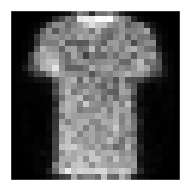

In [131]:
generate("T-shirt")

Ankle boot


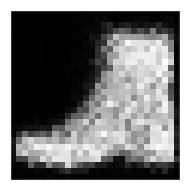

In [132]:
generate("Ankle boot")

Dress


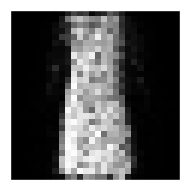

In [139]:
generate("Dress")

Sneaker


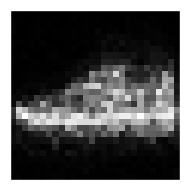

In [140]:
generate("Sneaker")

Sandal


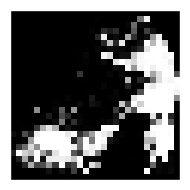

In [150]:
generate("Sandal")

Bag


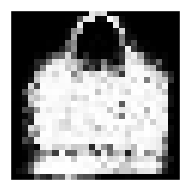

In [153]:
generate("Bag")

# Print randomly generated images from each class

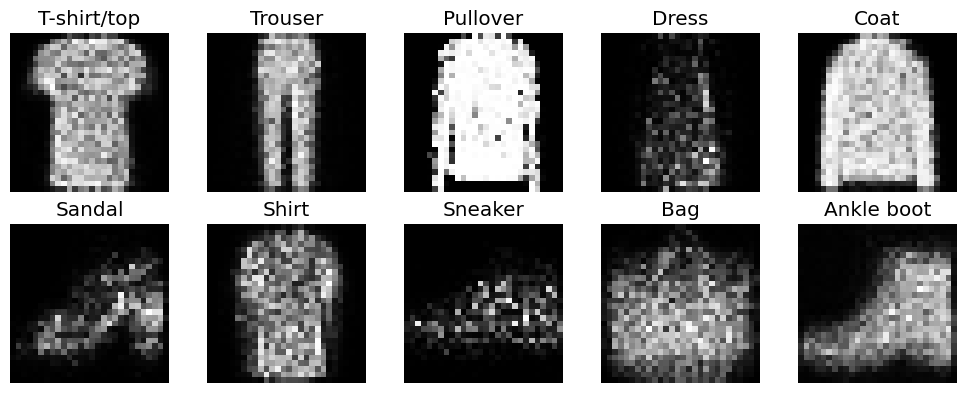

In [136]:
def generate_images_for_labels():
    """
    Generate and display fake images for each label in the Fashion MNIST dataset.

    This function creates a grid of images, where each image corresponds to a specific label from the 
    Fashion MNIST dataset. It uses the respective generator for each label to produce the images.

    Returns
    -------
    None
    """
    n_labels = 10
    
    fig, axs = plt.subplots(2, 5, figsize=(10, 4))
    
    for label in range(n_labels):
        generators[label].to('cpu')
        generators[label].eval()
        
        z = np.random.uniform(-1, 1, size=(1, 100))
        z = torch.from_numpy(z).float()
        fake_image = generators[label](z)
        fake_image = fake_image.view(1, 1, 28, 28).detach()
        
        ax = axs[label // 5, label % 5]
        image = fake_image.permute(0, 2, 3, 1).squeeze()
        ax.imshow(image, cmap='gray')
        ax.set_title(f'{fashion_mnist_labels[label]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

generate_images_for_labels()